# Application of text mining for understanding data protection incidents from penalty notices


The research, written in relation to completion of the Master of Science, explores the possible application of text mining techniques in legal documents. The chosen theme was the penalty notices associated with data protection incidents that occurred after the introduction of the General Data Protection Regulation (GDPR) in 2016. The primary objectives of the research include identifying the common causes for data breaches and answering the question how these may influence the severity of the penalty given.

In [2]:
# SETUP: downloading necessary packages, after completion restarting is necessary in order to use the notebook
!pip install PyPDF2 pandas nltk spacy gensim scikit-learn matplotlib seaborn -q
!python -m spacy download en_core_web_sm
!pip install pyLDAvis


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 101.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 124.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 113.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 117.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 146.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 41.2 MB/s eta 0:00:00


In [1]:
# IMPORTS: importing libraries to use
import os
import re
import PyPDF2
import pandas as pd
import nltk
from nltk.corpus import stopwords
from gensim import corpora, models
import spacy
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from google.colab import files
import nltk

# INIT: loading the trained pipeline for later use, setting up english stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Due to having difficulties with downloading big zipfiles from Google Drive, manual upload was needed for the penalty notices

In [3]:
#File upload dialog, due to difficulties imprting large file from Google Drive
uploaded = files.upload()


Saving ALL_metadata.xlsx to ALL_metadata.xlsx


The source for the files are https://www.enforcementtracker.com/, which is a GDPR penalty tracking website operated by a law firm. Both the text docuemnts and the meta information were extracted from their database, used as secondary source for the research.

In [4]:
# Unzip the uploaded zip file
!unzip ENG_PDF.zip -d gdpr_pdfs

Archive:  ENG_PDF.zip
  inflating: gdpr_pdfs/ETid-570.pdf  
  inflating: gdpr_pdfs/ETid-689.pdf  
  inflating: gdpr_pdfs/ETid-752.pdf  
  inflating: gdpr_pdfs/ETid-820.pdf  
  inflating: gdpr_pdfs/ETid-847.pdf  
  inflating: gdpr_pdfs/ETid-875.pdf  
  inflating: gdpr_pdfs/ETid-893.pdf  
  inflating: gdpr_pdfs/ETid-930.pdf  
  inflating: gdpr_pdfs/ETid-987.pdf  
  inflating: gdpr_pdfs/ETid-1009.pdf  
  inflating: gdpr_pdfs/ETid-1188.pdf  
  inflating: gdpr_pdfs/ETid-1190.pdf  
  inflating: gdpr_pdfs/ETid-1250.pdf  
  inflating: gdpr_pdfs/ETid-1352.pdf  
  inflating: gdpr_pdfs/ETid-1373.pdf  
  inflating: gdpr_pdfs/ETid-1422.pdf  
  inflating: gdpr_pdfs/ETid-1461.pdf  
  inflating: gdpr_pdfs/ETid-1543.pdf  
  inflating: gdpr_pdfs/ETid-1564.pdf  
  inflating: gdpr_pdfs/ETid-1578.pdf  
  inflating: gdpr_pdfs/ETid-1666.pdf  
  inflating: gdpr_pdfs/ETid-1677.pdf  
  inflating: gdpr_pdfs/ETid-1696.pdf  
  inflating: gdpr_pdfs/ETid-1844.pdf  
  inflating: gdpr_pdfs/ETid-1910.pdf  
  inflating:

In [67]:
# Extracting text from PDFs using a for loop on the target directory
def extract_text_from_pdfs(pdf_dir):
    texts = {}
    for filename in os.listdir(pdf_dir):
        if filename.endswith('.pdf'):
            with open(os.path.join(pdf_dir, filename), 'rb') as f:
                reader = PyPDF2.PdfReader(f)
                text = " ".join(page.extract_text() for page in reader.pages)
                texts[filename] = text
    return texts

# Replace with your path
pdf_dir = 'gdpr_pdfs'  # Adjust if needed
texts = extract_text_from_pdfs(pdf_dir)
print(f"Extracted {len(texts)} PDF(s). Sample:\n{list(texts.keys())[:2]}")


[0, IndirectObject(3994, 0, 138495202524304)]
[0, IndirectObject(3989, 0, 138495202524304)]
[0, IndirectObject(3984, 0, 138495202524304)]
[0, IndirectObject(3979, 0, 138495202524304)]
[0, IndirectObject(3974, 0, 138495202524304)]
[0, IndirectObject(3969, 0, 138495202524304)]
[0, IndirectObject(3935, 0, 138495202524304)]
[0, IndirectObject(3930, 0, 138495202524304)]
[0, IndirectObject(3925, 0, 138495202524304)]
[0, IndirectObject(3920, 0, 138495202524304)]
[0, IndirectObject(3915, 0, 138495202524304)]
[0, IndirectObject(3889, 0, 138495202524304)]
[0, IndirectObject(3884, 0, 138495202524304)]
[0, IndirectObject(3879, 0, 138495202524304)]
[0, IndirectObject(3874, 0, 138495202524304)]
[0, IndirectObject(3852, 0, 138495202524304)]
[0, IndirectObject(3847, 0, 138495202524304)]
[0, IndirectObject(3842, 0, 138495202524304)]
[0, IndirectObject(3837, 0, 138495202524304)]
[0, IndirectObject(3832, 0, 138495202524304)]
[0, IndirectObject(2554, 0, 138495202524304)]
[0, IndirectObject(2549, 0, 138495

Extracted 37 PDF(s). Sample:
['ETid-875.pdf', 'ETid-552.pdf']


In [6]:
#Reading the extracted Engagement Tracker data into a dataframe
df_meta=pd.read_excel('ALL_metadata.xlsx')
df_meta.head()

,Unnamed: 0,ETid,Country,Authority,Date of Decision,Fine [€],Controller/Processor,Sector,Quoted Art.,Type,Summary,Source1,Source2
0,NaN,ETid-2566,UNITED KINGDOM,Information Commissioner (ICO),2025-04-14 00:00:00,70300,DPP Law Ltd.,"Finance, Insurance and Consulting","Art. 5 (1) f) GDPR, Art. 32 (1), (2) GDPR, Art...",Insufficient technical and organisational meas...,"The UK DPA (ICO) has imposed a fine of £ 60,00...",link,https://www.enforcementtracker.com/ETid-2566 (...
1,NaN,ETid-2561,UNITED KINGDOM,Information Commissioner (ICO),2025-03-26 00:00:00,3500000,Advanced Computer Software Group Ltd,Health Care,Art. 32 (1) GDPR,Insufficient technical and organisational meas...,The UK DPA (ICO) has fined Advanced Computer S...,link link,https://www.enforcementtracker.com/ETid-2561 (...
2,NaN,ETid-2555,UNITED KINGDOM,Information Commissioner (ICO),2024-09-26 00:00:00,904000,Police Service of Northern Ireland,Public Sector and Education,"Art. 5 (1) f) GDPR, Art. 32 (1), (2) GDPR",Insufficient technical and organisational meas...,The ICO fined the Police Service of Northern I...,link link,https://www.enforcementtracker.com/ETid-2555 (...
3,NaN,ETid-2317,UNITED KINGDOM,Information Commissioner (ICO),2024-04-30 00:00:00,8700,Central Young Men’s Christian Association,Individuals and Private Associations,"Art. 5 (1) f) GDPR, Art. 32 (1), (2) GDPR",Insufficient technical and organisational meas...,The UK DPA (ICO) has fined the Central Young M...,link link,https://www.enforcementtracker.com/ETid-2317 (...
4,NaN,ETid-2170,UNITED KINGDOM,Information Commissioner (ICO),2023-12-13 00:00:00,400000,UK Ministry of Defense,Public Sector and Education,Unknown,Insufficient technical and organisational meas...,The UK DPA has fined the Ministry of Defense E...,link,https://www.enforcementtracker.com/ETid-2170 (...


# Exploratory data analysis

In [7]:
# prompt: help me filter the df_meta usiing the filename from texts on column Etid and replace the .pdf from filenames

def filter_and_replace(df, texts):
    """Filters the DataFrame based on filenames in 'texts' and replaces .pdf."""

    # Extract filenames without .pdf extension from the texts dictionary keys
    filenames_no_pdf = [filename[:-4] for filename in texts.keys()]

    # Filter the DataFrame to include only rows where 'Etid' is in the filenames
    df_filtered = df[df['ETid'].isin(filenames_no_pdf)]

    return df_filtered

# Apply the function
df_meta = filter_and_replace(df_meta, texts)

# Display the filtered DataFrame (optional)
df_meta.head()


,Unnamed: 0,ETid,Country,Authority,Date of Decision,Fine [€],Controller/Processor,Sector,Quoted Art.,Type,Summary,Source1,Source2
0,NaN,ETid-2566,UNITED KINGDOM,Information Commissioner (ICO),2025-04-14 00:00:00,70300,DPP Law Ltd.,"Finance, Insurance and Consulting","Art. 5 (1) f) GDPR, Art. 32 (1), (2) GDPR, Art...",Insufficient technical and organisational meas...,"The UK DPA (ICO) has imposed a fine of £ 60,00...",link,https://www.enforcementtracker.com/ETid-2566 (...
1,NaN,ETid-2561,UNITED KINGDOM,Information Commissioner (ICO),2025-03-26 00:00:00,3500000,Advanced Computer Software Group Ltd,Health Care,Art. 32 (1) GDPR,Insufficient technical and organisational meas...,The UK DPA (ICO) has fined Advanced Computer S...,link link,https://www.enforcementtracker.com/ETid-2561 (...
2,NaN,ETid-2555,UNITED KINGDOM,Information Commissioner (ICO),2024-09-26 00:00:00,904000,Police Service of Northern Ireland,Public Sector and Education,"Art. 5 (1) f) GDPR, Art. 32 (1), (2) GDPR",Insufficient technical and organisational meas...,The ICO fined the Police Service of Northern I...,link link,https://www.enforcementtracker.com/ETid-2555 (...
3,NaN,ETid-2317,UNITED KINGDOM,Information Commissioner (ICO),2024-04-30 00:00:00,8700,Central Young Men’s Christian Association,Individuals and Private Associations,"Art. 5 (1) f) GDPR, Art. 32 (1), (2) GDPR",Insufficient technical and organisational meas...,The UK DPA (ICO) has fined the Central Young M...,link link,https://www.enforcementtracker.com/ETid-2317 (...
6,NaN,ETid-1461,UNITED KINGDOM,Information Commissioner (ICO),2022-10-19 00:00:00,5033000,Interserve Group Limited,Industry and Commerce,"Art. 5 (1) f) GDPR, Art. 32 GDPR",Insufficient technical and organisational meas...,The British DPA has fined the construction gro...,link link,https://www.enforcementtracker.com/ETid-1461 (...


In [8]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37 entries, 0 to 64
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            0 non-null      float64
 1   ETid                  37 non-null     object 
 2   Country               37 non-null     object 
 3   Authority             37 non-null     object 
 4   Date of Decision      37 non-null     object 
 5   Fine [€]              37 non-null     object 
 6   Controller/Processor  37 non-null     object 
 7   Sector                37 non-null     object 
 8   Quoted Art.           37 non-null     object 
 9   Type                  37 non-null     object 
 10  Summary               37 non-null     object 
 11  Source1               37 non-null     object 
 12  Source2               37 non-null     object 
dtypes: float64(1), object(12)
memory usage: 5.1+ KB


From calling the info() function we can see that all data is objects, which is not optimal for further analysis. The data should have contained float for the fees and datetime for the date of decision

In [9]:
df_meta['Fine [€]'].unique()

array([70300, 3500000, 904000, 8700, 5033000, 1547000, 91000, 9000000,
       115000, 585000, 29000, 1405000, 20450000, 345000000, 22500,
       1200000000, 750000, 15000, 460000, 5500000, 100000, 390000000,
       405000000, 110000, 60000, 1500, 'Only intention to issue fine',
       225000000, 90000, 85000, 70000, 450000, 75000, 2500, 202000, 3250,
       13500], dtype=object)

From the unique values, the problem is apparent that there is a string within the fees, which will be set to 0 as the decision was not made.

In [10]:
df_meta['Fine [€]'].replace('Only intention to issue fine', 0, inplace=True)

<ipython-input-10-ed8caeb34281>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_meta['Fine [€]'].replace('Only intention to issue fine', 0, inplace=True)
<ipython-input-10-ed8caeb34281>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_meta['Fine [€]'].replace('Only intention to issue fine', 0

Getting the unique values for each breached article column returns a messy dataset. To fix this the column has to be spli first, then "exploded" into multiple rows.

In [11]:
df_meta['Quoted Art.'].unique()

array(['Art. 5 (1) f) GDPR, Art. 32 (1), (2) GDPR, Art. 33 (1) GDPR',
       'Art. 32 (1) GDPR', 'Art. 5 (1) f) GDPR, Art. 32 (1), (2) GDPR',
       'Art. 5 (1) f) GDPR, Art. 32 GDPR',
       'Art. 5 (1) a) GDPR, Art. 6 GDPR, Art. 9 GDPR, Art. 13 (1) c) GDPR, Regulation 21 PECR',
       'Art. 5 (1) a), e) GDPR, Art. 6 GDPR, Art. 9 GDPR, Art. 14 GDPR, Art. 15 GDPR, Art. 16 GDPR, Art. 17 GDPR, Art. 21 GDPR, Art. 22 GDPR, Art. 35 GDPR',
       'Art. 5 (1) a) f) GDPR', 'Art. 32 GDPR',
       'Art. 5 (1) c), 5 (1) f) GDPR, Art. 12 (1) GDPR, Art. 13 (1) e) GDPR, Art. 24 (1) GDPR, Art. 25 (1), (2) GDPR',
       'Art. 5 (1) c) GDPR, Art. 6 (1), (4) GDPR, Art. 9 (1) GDPR',
       'Art. 46 (1) GDPR', 'Art. 5 (1) f) GDPR, Art. 32 (1) GDPR',
       'Art. 5 (1) f) GDPR, Art. 5 (2) GDPR, Art. 32 (1) GDPR',
       'Art. 6 (1) GDPR, Art. 12 GDPR, Art. 13 (1) c) GDPR',
       'Art. 5 (1) a) GDPR, Art. 6 (1) GDPR, Art. 12 GDPR, Art. 13 (1) c) GDPR',
       'Art. 5 (1) a), c) GDPR, Art. 6 (1) GDPR, Art. 

In [13]:
# Clean metadata - drop 'Unnamed', 'Source1', 'Source2'
metadata_df_cleaned = df_meta.drop(columns=[col for col in df_meta.columns if 'Unnamed' in col or col in ['Source1', 'Source2']])

# Normalize 'Quoted Art.' column by splitting and exploding
metadata_df_cleaned['Quoted Art.'] = metadata_df_cleaned['Quoted Art.'].fillna('Unknown')
metadata_df_cleaned['Quoted Art.'] = metadata_df_cleaned['Quoted Art.'].str.replace('Art. ', '', regex=False)
metadata_df_cleaned['Quoted Art.'] = metadata_df_cleaned['Quoted Art.'].str.split(', ')
metadata_exploded = metadata_df_cleaned.explode('Quoted Art.')
metadata_exploded['Quoted Art.'] = 'Art. ' + metadata_exploded['Quoted Art.'].str.strip()

# Create a simplified version
# Keep only the base article (e.g., 'Art. 5', 'Art. 6') and remove subpoints like (1), (2), a), b), etc.
metadata_exploded['Quoted Art. Simple'] = metadata_exploded['Quoted Art.'].str.extract(r'(Art\.\s*\d+)')
metadata_exploded = metadata_exploded.dropna()

From the exploded rows NULL values are dropped as they are related to the same article, but due to splitting with commas the second subsection is incorrecly empty. Dropping is preferred here as using forward filling creates duplicates.

In [14]:
metadata_exploded.head()

,ETid,Country,Authority,Date of Decision,Fine [€],Controller/Processor,Sector,Quoted Art.,Type,Summary,Quoted Art. Simple
0,ETid-2566,UNITED KINGDOM,Information Commissioner (ICO),2025-04-14 00:00:00,70300,DPP Law Ltd.,"Finance, Insurance and Consulting",Art. 5 (1) f) GDPR,Insufficient technical and organisational meas...,"The UK DPA (ICO) has imposed a fine of £ 60,00...",Art. 5
0,ETid-2566,UNITED KINGDOM,Information Commissioner (ICO),2025-04-14 00:00:00,70300,DPP Law Ltd.,"Finance, Insurance and Consulting",Art. 32 (1),Insufficient technical and organisational meas...,"The UK DPA (ICO) has imposed a fine of £ 60,00...",Art. 32
0,ETid-2566,UNITED KINGDOM,Information Commissioner (ICO),2025-04-14 00:00:00,70300,DPP Law Ltd.,"Finance, Insurance and Consulting",Art. 33 (1) GDPR,Insufficient technical and organisational meas...,"The UK DPA (ICO) has imposed a fine of £ 60,00...",Art. 33
1,ETid-2561,UNITED KINGDOM,Information Commissioner (ICO),2025-03-26 00:00:00,3500000,Advanced Computer Software Group Ltd,Health Care,Art. 32 (1) GDPR,Insufficient technical and organisational meas...,The UK DPA (ICO) has fined Advanced Computer S...,Art. 32
2,ETid-2555,UNITED KINGDOM,Information Commissioner (ICO),2024-09-26 00:00:00,904000,Police Service of Northern Ireland,Public Sector and Education,Art. 5 (1) f) GDPR,Insufficient technical and organisational meas...,The ICO fined the Police Service of Northern I...,Art. 5


Simple group by to see and understand the data using simple statistical measures.

In [15]:
# Group by simplified article and calculate summary statistics
article_summary = metadata_exploded.groupby('Quoted Art. Simple').agg(
    total_fines=('Fine [€]', 'sum'),
    average_fine=('Fine [€]', 'mean'),
    case_count=('Fine [€]', 'count')
).reset_index().sort_values(by='total_fines', ascending=False)

print(article_summary)

   Quoted Art. Simple  total_fines  average_fine  case_count
17             Art. 5   1731283500  5.770945e+07          30
0             Art. 12   1370626000  1.522918e+08           9
16            Art. 46   1200000000  1.200000e+09           1
1             Art. 13    967159500  1.208949e+08           8
19             Art. 6    811144500  1.158778e+08           7
8             Art. 24    750294500  1.500589e+08           5
9             Art. 25    750292000  1.875730e+08           4
14            Art. 35    414000000  2.070000e+08           2
2             Art. 14    234002500  7.800083e+07           3
11            Art. 32     33819500  1.779974e+06          19
20             Art. 9     10569500  3.523167e+06           3
3             Art. 15      9126000  2.281500e+06           4
7             Art. 22      9000000  9.000000e+06           1
6             Art. 21      9000000  9.000000e+06           1
5             Art. 17      9000000  9.000000e+06           1
4             Art. 16   

<ipython-input-16-4b107866d5c0>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top5, x='total_fines', y='Quoted Art. Simple', palette='Greens_d', ax=ax1)
<ipython-input-16-4b107866d5c0>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom5, x='total_fines', y='Quoted Art. Simple', palette='Reds_d', ax=ax2)


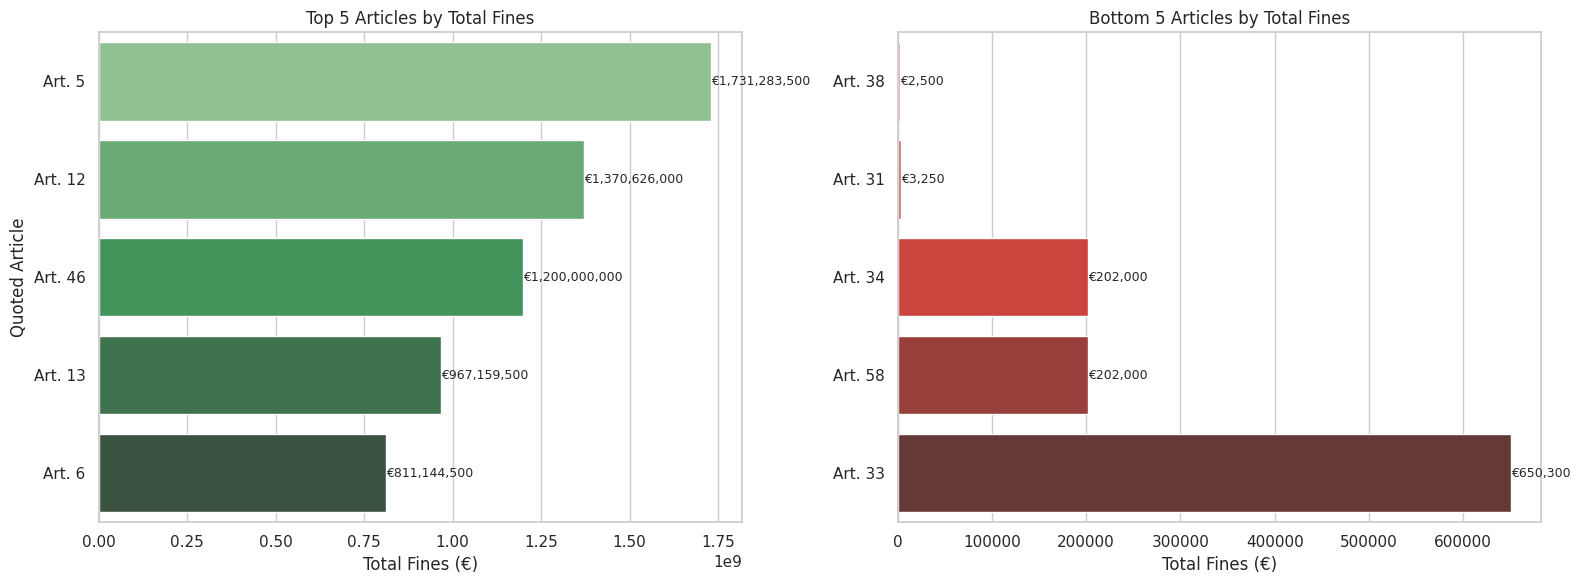

In [16]:
# Prepare top and bottom 5
top5 = article_summary.nlargest(5, 'total_fines')
bottom5 = article_summary.nsmallest(5, 'total_fines')

sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top 5
sns.barplot(data=top5, x='total_fines', y='Quoted Art. Simple', palette='Greens_d', ax=ax1)
ax1.set_title('Top 5 Articles by Total Fines')
ax1.set_xlabel('Total Fines (€)')
ax1.set_ylabel('Quoted Article')
for bar, value in zip(ax1.patches, top5['total_fines']):
    ax1.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f"€{value:,.0f}",
             va='center', ha='left', fontsize=9)

# Bottom 5
sns.barplot(data=bottom5, x='total_fines', y='Quoted Art. Simple', palette='Reds_d', ax=ax2)
ax2.set_title('Bottom 5 Articles by Total Fines')
ax2.set_xlabel('Total Fines (€)')
ax2.set_ylabel('')
for bar, value in zip(ax2.patches, bottom5['total_fines']):
    ax2.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f"€{value:,.0f}",
             va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()


<ipython-input-17-d336317453b4>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top5, x='average_fine', y='Quoted Art. Simple', palette='Greens_d', ax=ax1)
<ipython-input-17-d336317453b4>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom5, x='average_fine', y='Quoted Art. Simple', palette='Reds_d', ax=ax2)


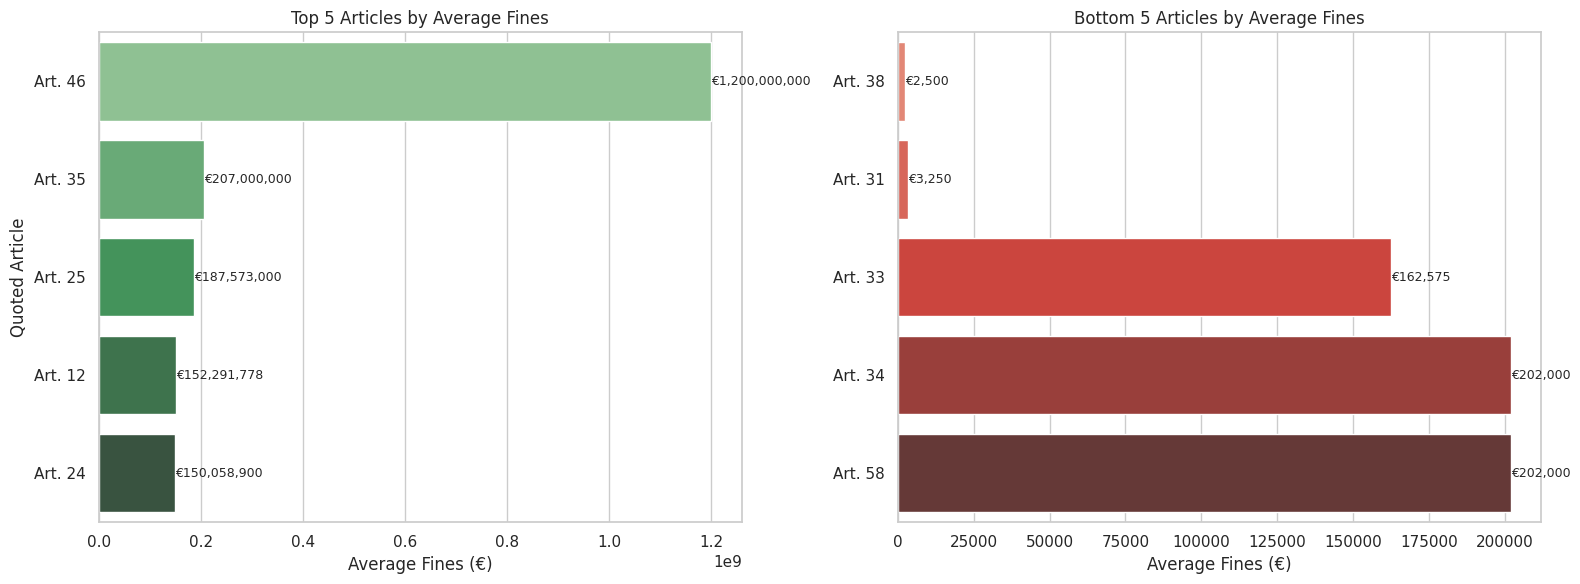

In [17]:
# Prepare top and bottom 5
top5 = article_summary.nlargest(5, 'average_fine')
bottom5 = article_summary.nsmallest(5, 'average_fine')

sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top 5
sns.barplot(data=top5, x='average_fine', y='Quoted Art. Simple', palette='Greens_d', ax=ax1)
ax1.set_title('Top 5 Articles by Average Fines')
ax1.set_xlabel('Average Fines (€)')
ax1.set_ylabel('Quoted Article')
for bar, value in zip(ax1.patches, top5['average_fine']):
    ax1.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f"€{value:,.0f}",
             va='center', ha='left', fontsize=9)

# Bottom 5
sns.barplot(data=bottom5, x='average_fine', y='Quoted Art. Simple', palette='Reds_d', ax=ax2)
ax2.set_title('Bottom 5 Articles by Average Fines')
ax2.set_xlabel('Average Fines (€)')
ax2.set_ylabel('')
for bar, value in zip(ax2.patches, bottom5['average_fine']):
    ax2.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f"€{value:,.0f}",
             va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()


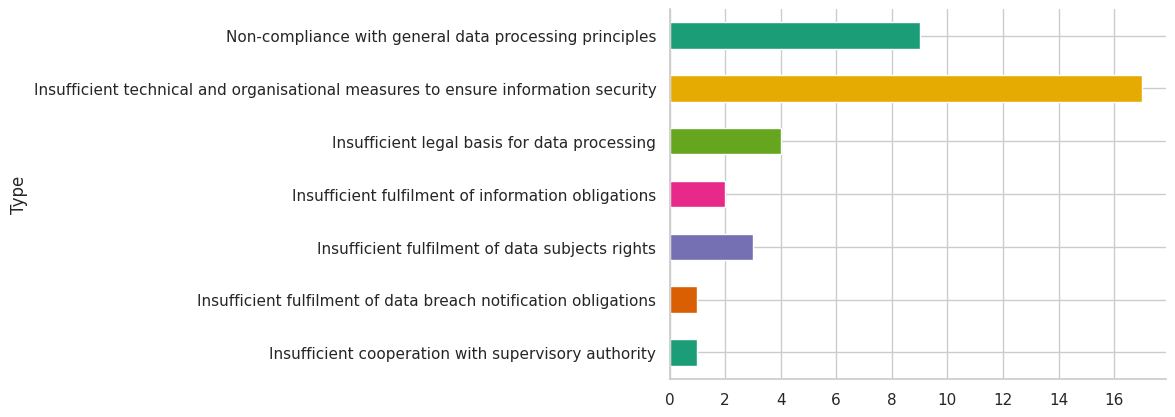

In [18]:
# @title Type

from matplotlib import pyplot as plt
import seaborn as sns
metadata_df_cleaned.groupby('Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

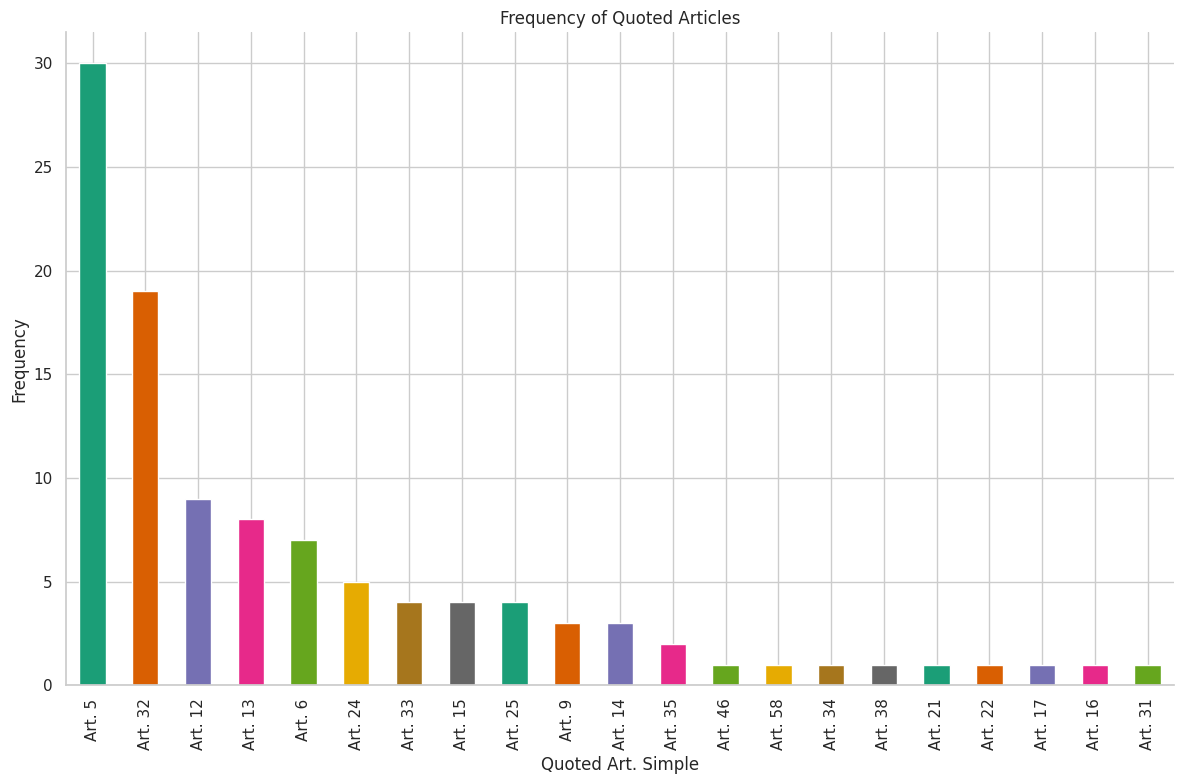

In [19]:
plt.figure(figsize=(12, 8))

# Count the occurrences of each article and plot as bar
article_counts = metadata_exploded['Quoted Art. Simple'].value_counts()

article_counts.plot(
    kind='bar',
    color=sns.color_palette('Dark2')
)

# Add labels and title
plt.title('Frequency of Quoted Articles')
plt.xlabel('Quoted Art. Simple')
plt.ylabel('Frequency')

# Improve readability
plt.xticks(rotation=90)
plt.gca().spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

In [20]:
# Keyword frequency analysis
def keyword_frequency(text, keywords):
    return {kw: text.lower().count(kw) for kw in keywords}

keywords = ['monitoring', 'encryption', 'access control', 'destruct', 'logging', 'transfer',
            'privacy', 'rights', 'vulnerability', 'child', 'personal data', 'breach', 'risk']

keyword_df = pd.DataFrame(
    [keyword_frequency(text, keywords) for text in texts.values()],
    index=texts.keys()
)
keyword_df.to_csv('keyword_frequency.csv')
keyword_df.style.background_gradient(cmap='Blues')

,monitoring,encryption,access control,destruct,logging,transfer,privacy,rights,vulnerability,child,personal data,breach,risk
ETid-875.pdf,0,0,0,2,0,8,5,34,0,4,132,14,13
ETid-552.pdf,0,0,0,0,0,0,0,0,0,0,7,4,0
ETid-1373.pdf,0,0,0,0,0,0,4,57,1,123,48,13,68
ETid-1422.pdf,0,0,0,1,0,1,7,5,0,0,32,14,5
ETid-2317.pdf,3,1,0,3,0,1,2,6,0,0,35,27,16
ETid-847.pdf,0,0,0,0,0,0,0,0,0,0,0,0,0
ETid-1677.pdf,0,0,0,0,0,0,0,0,0,0,0,0,0
ETid-570.pdf,3,5,1,4,0,6,10,61,0,44,374,330,187
ETid-689.pdf,0,0,0,0,0,2,1,22,0,0,140,59,48
ETid-1910.pdf,0,0,0,0,0,0,0,0,0,0,0,0,0


After the writing the keywords frequency to a csv file, the data can be read into a dataframe to avoid uploading and extarcting each PDF again.

In [21]:
keywords_df = pd.read_csv('keyword_frequency.csv')

In [22]:
keywords_df.head()

,Unnamed: 0,monitoring,encryption,access control,destruct,logging,transfer,privacy,rights,vulnerability,child,personal data,breach,risk
0,ETid-875.pdf,0,0,0,2,0,8,5,34,0,4,132,14,13
1,ETid-552.pdf,0,0,0,0,0,0,0,0,0,0,7,4,0
2,ETid-1373.pdf,0,0,0,0,0,0,4,57,1,123,48,13,68
3,ETid-1422.pdf,0,0,0,1,0,1,7,5,0,0,32,14,5
4,ETid-2317.pdf,3,1,0,3,0,1,2,6,0,0,35,27,16


In [23]:
metadata_exploded['ETid'] = metadata_exploded['ETid'].astype(str).str.strip() + '.pdf'

merged_df = metadata_exploded.merge(keywords_df, left_on='ETid', right_on='Unnamed: 0')

In [24]:
merged_df.head()

,ETid,Country,Authority,Date of Decision,Fine [€],Controller/Processor,Sector,Quoted Art.,Type,Summary,...,destruct,logging,transfer,privacy,rights,vulnerability,child,personal data,breach,risk
0,ETid-2566.pdf,UNITED KINGDOM,Information Commissioner (ICO),2025-04-14 00:00:00,70300,DPP Law Ltd.,"Finance, Insurance and Consulting",Art. 5 (1) f) GDPR,Insufficient technical and organisational meas...,"The UK DPA (ICO) has imposed a fine of £ 60,00...",...,3,0,1,3,15,1,15,67,47,47
1,ETid-2566.pdf,UNITED KINGDOM,Information Commissioner (ICO),2025-04-14 00:00:00,70300,DPP Law Ltd.,"Finance, Insurance and Consulting",Art. 32 (1),Insufficient technical and organisational meas...,"The UK DPA (ICO) has imposed a fine of £ 60,00...",...,3,0,1,3,15,1,15,67,47,47
2,ETid-2566.pdf,UNITED KINGDOM,Information Commissioner (ICO),2025-04-14 00:00:00,70300,DPP Law Ltd.,"Finance, Insurance and Consulting",Art. 33 (1) GDPR,Insufficient technical and organisational meas...,"The UK DPA (ICO) has imposed a fine of £ 60,00...",...,3,0,1,3,15,1,15,67,47,47
3,ETid-2561.pdf,UNITED KINGDOM,Information Commissioner (ICO),2025-03-26 00:00:00,3500000,Advanced Computer Software Group Ltd,Health Care,Art. 32 (1) GDPR,Insufficient technical and organisational meas...,The UK DPA (ICO) has fined Advanced Computer S...,...,0,0,0,0,0,0,0,0,0,0
4,ETid-2555.pdf,UNITED KINGDOM,Information Commissioner (ICO),2024-09-26 00:00:00,904000,Police Service of Northern Ireland,Public Sector and Education,Art. 5 (1) f) GDPR,Insufficient technical and organisational meas...,The ICO fined the Police Service of Northern I...,...,2,0,1,2,10,0,5,66,42,48


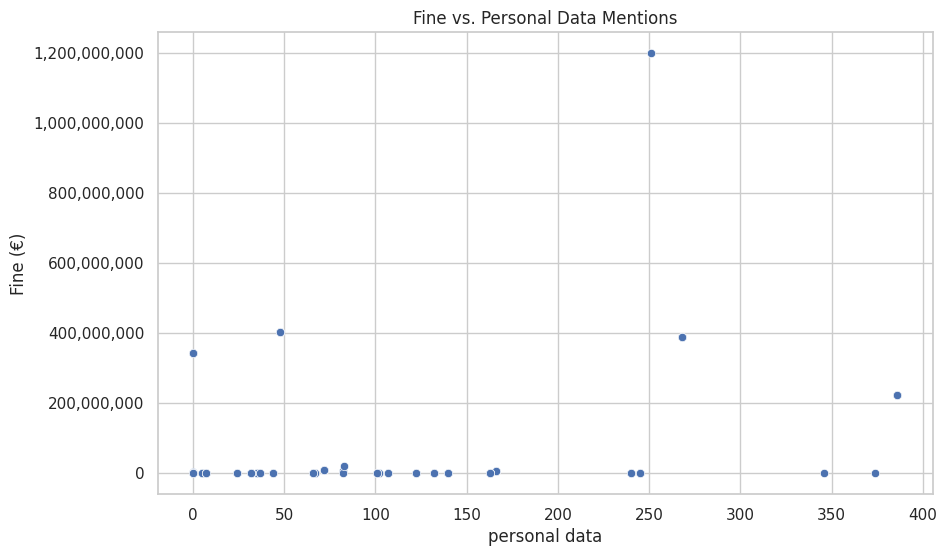

In [25]:
plt.figure(figsize=(10, 6))
# Create the scatter plot with Seaborn
scatter_plot = sns.scatterplot(data=merged_df, x='personal data', y='Fine [€]')

# Format y-axis labels to display full numbers instead of scientific notation
scatter_plot.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Add a y-axis label
plt.ylabel('Fine (€)')

plt.title('Fine vs. Personal Data Mentions')
plt.show()

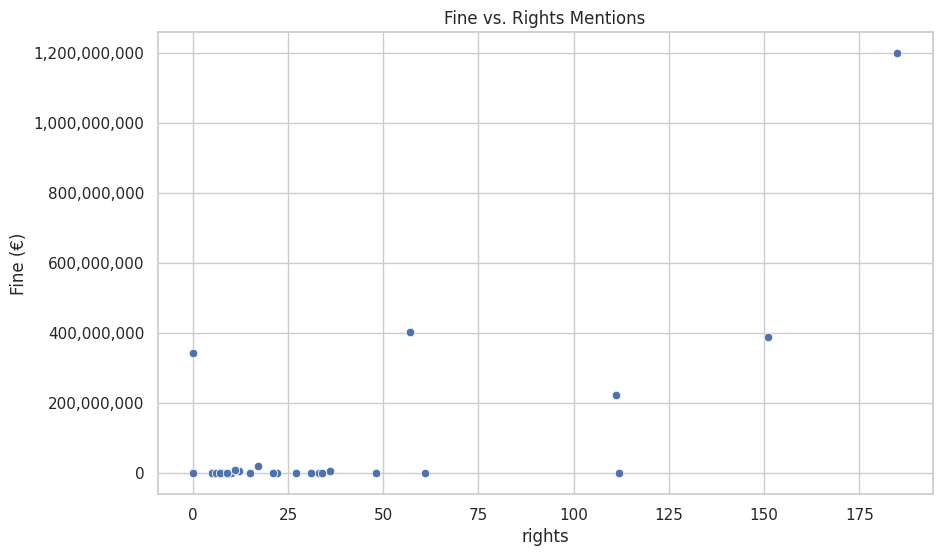

In [26]:
plt.figure(figsize=(10, 6))
# Create the scatter plot with Seaborn
scatter_plot = sns.scatterplot(data=merged_df, x='rights', y='Fine [€]')

# Format y-axis labels to display full numbers instead of scientific notation
scatter_plot.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Add a y-axis label
plt.ylabel('Fine (€)')

plt.title('Fine vs. Rights Mentions')
plt.show()

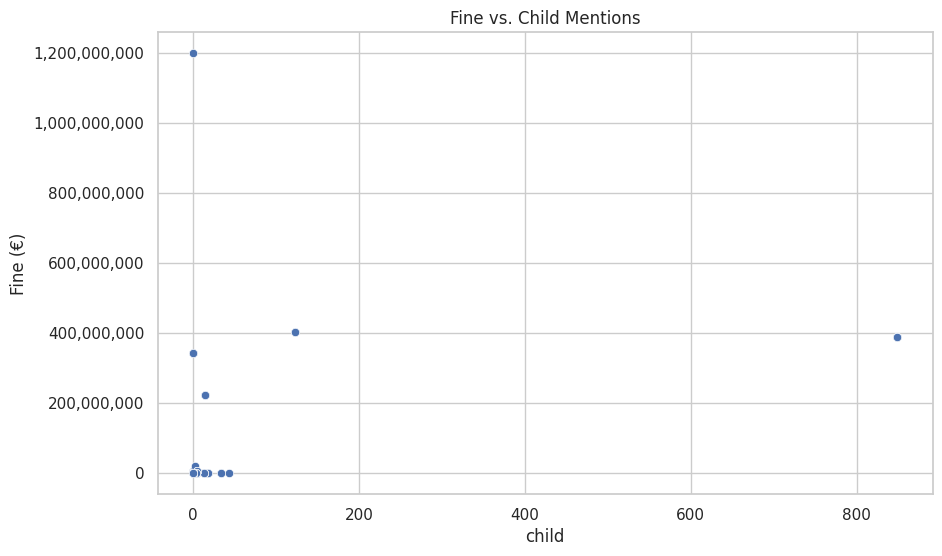

In [27]:
plt.figure(figsize=(10, 6))
# Create the scatter plot with Seaborn
scatter_plot = sns.scatterplot(data=merged_df, x='child', y='Fine [€]')

# Format y-axis labels to display full numbers instead of scientific notation
scatter_plot.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Add a y-axis label
plt.ylabel('Fine (€)')

plt.title('Fine vs. Child Mentions')
plt.show()

In [28]:
def get_text(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
    ]
    return tokens

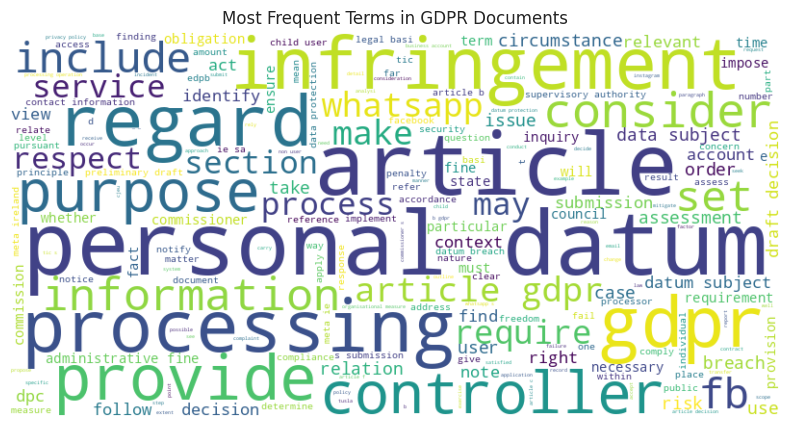

In [29]:
raw_texts = [get_text(text) for text in texts.values()]
text_string = " ".join([" ".join(raw_texts) for raw_texts in raw_texts ])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_string)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Terms in GDPR Documents")
plt.show()

In [30]:
def clean_text(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha and not token.is_stop and len(token) > 2
    ]
    return tokens

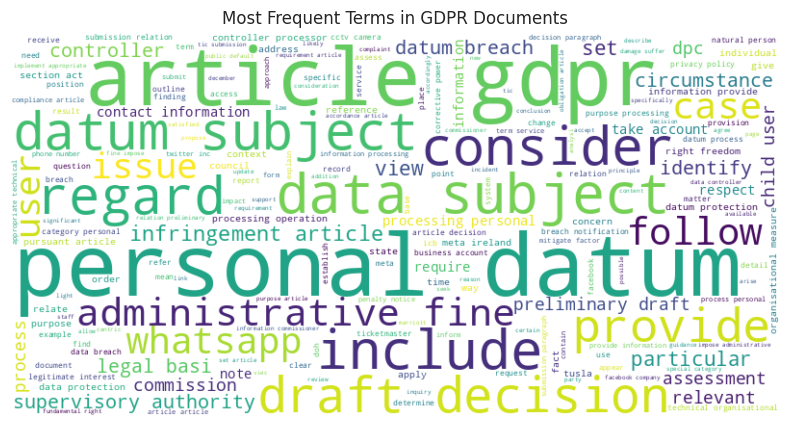

In [31]:
# Correctly apply clean_text to each text in the texts dictionary
cleaned_texts = [clean_text(text) for text in texts.values()]
text_string = " ".join([" ".join(cleaned_text) for cleaned_text in cleaned_texts ])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_string)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Terms in GDPR Documents")
plt.show()

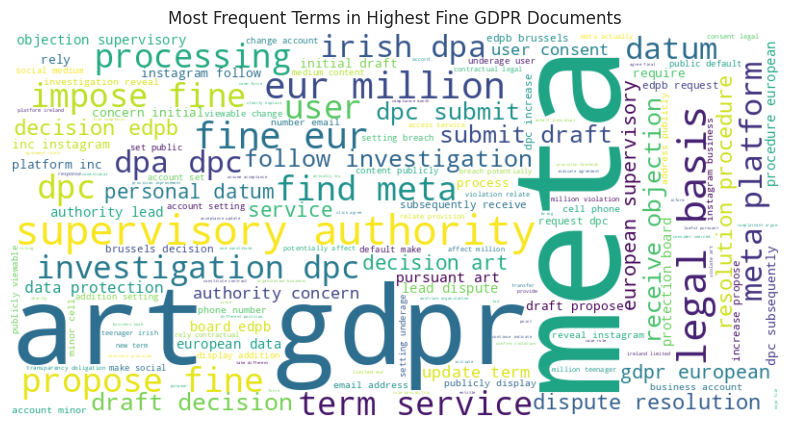

In [32]:
# Filter for highest fines
highest_fines_df = merged_df.nlargest(10, 'Fine [€]') # Select top 10 based on Fine column

# Combine text from highest fine documents
text_string = " ".join(highest_fines_df['Summary'].astype(str).tolist())

cleaned_text = clean_text(text_string)  # Example assuming 'clean_text' function is available
text_string = " ".join(cleaned_text)

# Create and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_string)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Terms in Highest Fine GDPR Documents")
plt.show()

         filename  num_words  num_chars  avg_word_length
0    ETid-875.pdf      45712     287159         6.281917
1    ETid-552.pdf        271       1701         6.276753
2   ETid-1373.pdf      39082     243061         6.219257
3   ETid-1422.pdf       8650      56186         6.495491
4   ETid-2317.pdf       6656      54164         8.137620
5    ETid-847.pdf          0          8         0.000000
6   ETid-1677.pdf          0         45         0.000000
7    ETid-570.pdf      30962     201585         6.510723
8    ETid-689.pdf      20174     127559         6.322940
9   ETid-1910.pdf          0         29         0.000000
10  ETid-1461.pdf      11776      77603         6.589929
11   ETid-930.pdf       9389      58979         6.281713
12  ETid-1965.pdf      42947     268774         6.258272
13   ETid-752.pdf       7189      44987         6.257755
14   ETid-440.pdf      19950     130560         6.544361
15   ETid-485.pdf      88059     544646         6.185012
16  ETid-1564.pdf      17038   

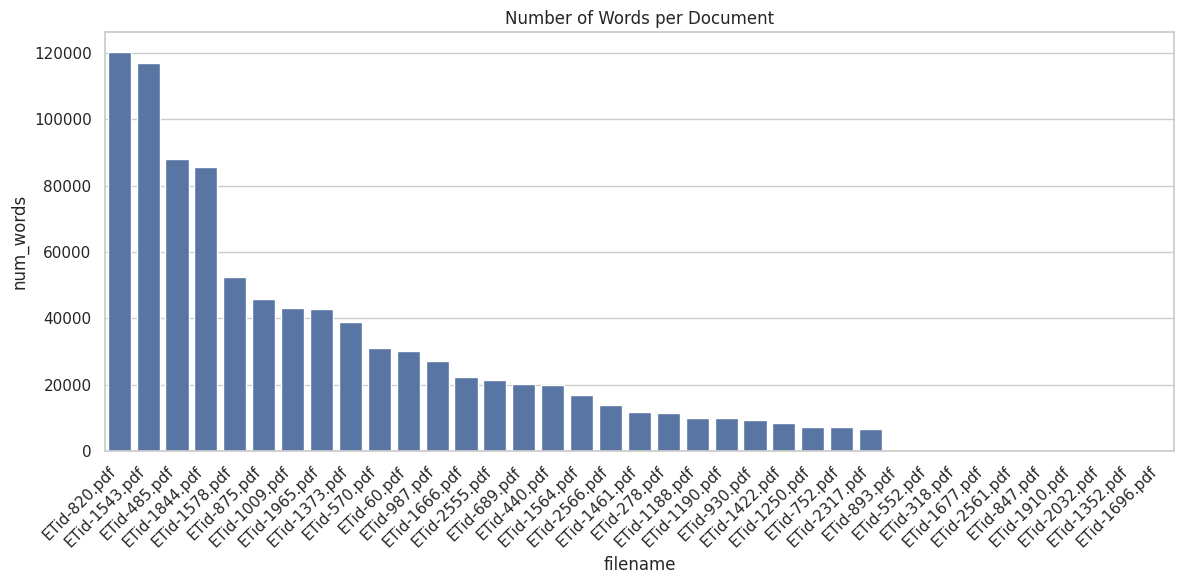

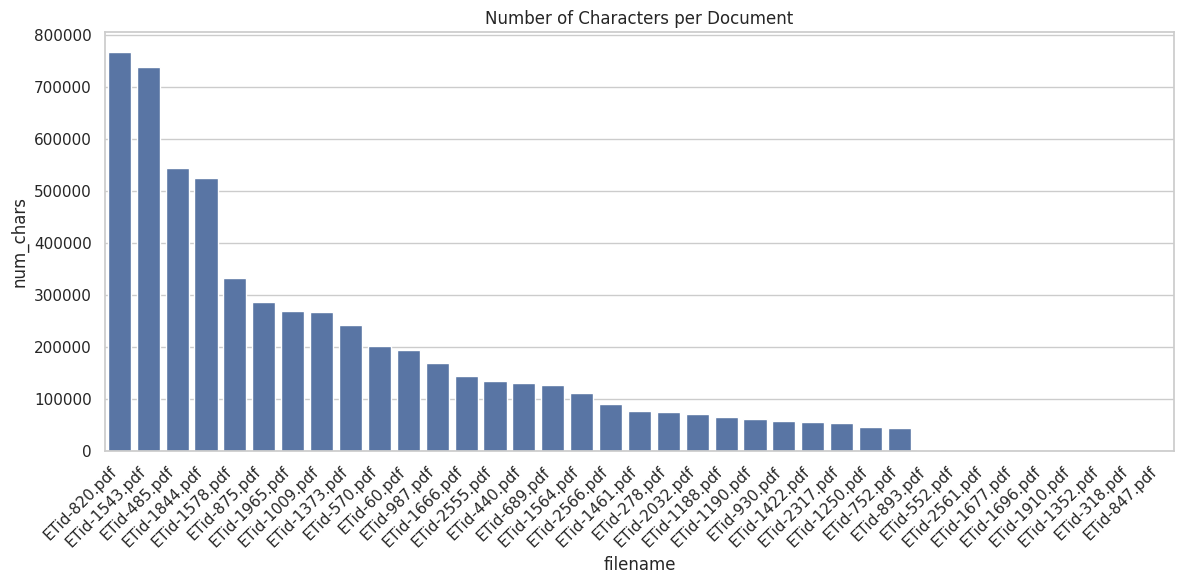


Top 10 1-grams:
data: 10709
article: 7315
gdpr: 5484
processing: 4749
personal: 4435
information: 4090
decision: 3322
controller: 2358
breach: 2231
whatsapp: 2230

Top 10 2-grams:
personal data: 4183
data subjects: 1469
article 83: 1223
draft decision: 1007
data protection: 987
article gdpr: 967
data subject: 897
article 33: 839
data breach: 767
processing personal: 674

Top 10 3-grams:
processing personal data: 660
personal data breach: 582
article 83 gdpr: 557
technical organisational measures: 366
article 65 decision: 347
categories personal data: 245
contact information processing: 240
relation preliminary draft: 226
submissions relation preliminary: 223
appropriate technical organisational: 209


In [33]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

# Compute text statistics
def compute_text_stats(texts):
    stats = []
    for filename, text in texts.items():
        words = text.split()
        stats.append({
            'filename': filename,
            'num_words': len(words),
            'num_chars': len(text),
            'avg_word_length': len(text) / len(words) if words else 0
        })
    return pd.DataFrame(stats)

# Visualize text stats
def visualize_stats(stats_df):
    plt.figure(figsize=(12, 6))
    sns.barplot(data=stats_df.sort_values(by='num_words', ascending=False), x='filename', y='num_words')
    plt.xticks(rotation=45, ha='right')
    plt.title("Number of Words per Document")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(data=stats_df.sort_values(by='num_chars', ascending=False), x='filename', y='num_chars')
    plt.xticks(rotation=45, ha='right')
    plt.title("Number of Characters per Document")
    plt.tight_layout()
    plt.show()

# N-gram Extraction (top 10 for each n)
def get_top_ngrams(texts, n=2, top_k=10):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    all_text = list(texts.values())
    X = vectorizer.fit_transform(all_text)
    counts = X.sum(axis=0).A1
    ngram_freq = dict(zip(vectorizer.get_feature_names_out(), counts))
    return Counter(ngram_freq).most_common(top_k)

# Run
# Stats & Visuals
stats_df = compute_text_stats(texts)
print(stats_df)
visualize_stats(stats_df)

# N-grams
for n in [1, 2, 3]:
    top_ngrams = get_top_ngrams(texts, n=n)
    print(f"\nTop {len(top_ngrams)} {n}-grams:")
    for phrase, freq in top_ngrams:
        print(f"{phrase}: {freq}")

In [36]:
def plot_coherence_vs_topics(texts, start=2, limit=20, step=2):
    tokenized_docs = [clean_text(text) for text in texts.values()]
    dictionary = corpora.Dictionary(tokenized_docs)
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

    coherences = []
    topic_range = list(range(start, limit, step))

    for num_topics in topic_range:
        model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary,
                                passes=30, alpha='asymmetric', eta='auto', random_state=42)
        coherence = CoherenceModel(model=model, texts=tokenized_docs, dictionary=dictionary, coherence='c_v').get_coherence()
        coherences.append(coherence)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(topic_range, coherences, marker='o')
    plt.title('Coherence Score vs Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.grid(True)
    plt.show()

    # Return both for further use
    return topic_range, coherences

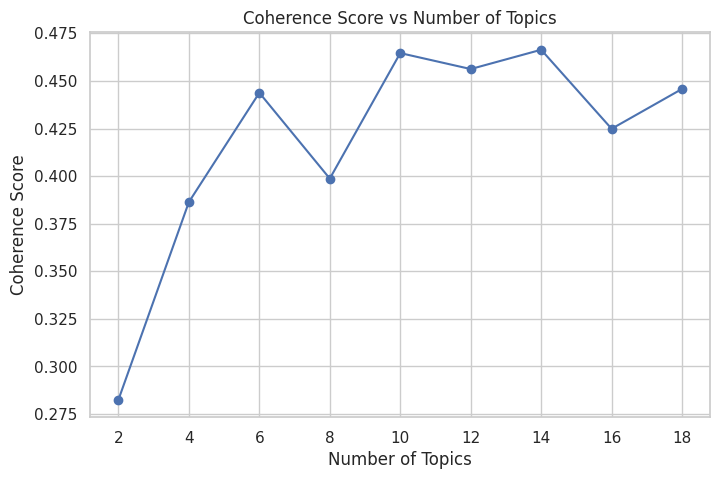

Best number of topics: 14


In [37]:
topic_range, coherences = plot_coherence_vs_topics(texts)

# Find the best number of topics
max_index = coherences.index(max(coherences))
best_num_topics = topic_range[max_index]

print(f"Best number of topics: {best_num_topics}")

In [38]:
# LDA Topic Modeling Function

def perform_topic_modeling(texts, num_topics=best_num_topics, passes=30):
    tokenized_docs = [clean_text(text) for text in texts.values()]
    dictionary = corpora.Dictionary(tokenized_docs)
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

    lda_model = models.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        passes=passes,
        alpha='asymmetric',
        eta='auto',
        random_state=42
    )

    coherence_model = CoherenceModel(model=lda_model, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()

    print(f"Coherence Score: {coherence_score:.4f}")
    for idx, topic in lda_model.print_topics():
        print(f"Topic {idx}: {topic}")

    return lda_model, corpus, dictionary, tokenized_docs


In [39]:
lda_model, corpus, dictionary, tokenized_docs = perform_topic_modeling(texts)

Coherence Score: 0.4664
Topic 0: 0.076*"dpc" + 0.071*"child" + 0.058*"allegation" + 0.052*"abuse" + 0.033*"inquiry" + 0.033*"neglect" + 0.027*"complainant" + 0.019*"week" + 0.015*"minimisation" + 0.013*"ict"
Topic 1: 0.087*"meta" + 0.072*"edpb" + 0.035*"objection" + 0.020*"cjeu" + 0.019*"sas" + 0.019*"dpc" + 0.012*"charter" + 0.012*"bind" + 0.011*"fundamental" + 0.010*"country"
Topic 2: 0.047*"representation" + 0.029*"attack" + 0.028*"para" + 0.019*"rap" + 0.018*"attacker" + 0.014*"dpa" + 0.008*"compromise" + 0.007*"card" + 0.007*"payment" + 0.007*"vulnerability"
Topic 3: 0.001*"whatsapp" + 0.001*"meta" + 0.001*"facebook" + 0.001*"inquiry" + 0.001*"edpb" + 0.001*"preliminary" + 0.001*"transparency" + 0.001*"guideline" + 0.001*"investigator" + 0.001*"dpc"
Topic 4: 0.034*"dpc" + 0.025*"inquiry" + 0.015*"server" + 0.014*"appendix" + 0.013*"reprimand" + 0.012*"backup" + 0.010*"password" + 0.010*"subsidiary" + 0.009*"management" + 0.009*"training"
Topic 5: 0.133*"whatsapp" + 0.029*"facebook

In [40]:
# Named Entity Recognition (NER)
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in ['ORG', 'GPE', 'MONEY']]

for filename, text in texts.items():
    entities = extract_entities(text)
    top_entities = pd.Series([ent[0] for ent in entities]).value_counts().head(20)
    print(f"\n📄 {filename} → {top_entities.to_dict()}")



📄 ETid-875.pdf → {'GDPR': 130, 'DPC': 96, 'Commission': 80, 'the Terms of Service': 54, 'Complaint': 52, 'Facebook’s': 26, 'Terms of Service': 24, 'EU': 23, 'the Preliminary Draft Decision': 15, 'the Data Policy': 13, 'Inquiry': 13, 'CJEU': 12, 'Data Policy': 11, 'Working Party': 10, 'Facebook Products': 10, 'Facebook Inc.': 7, 'Facebook, Inc.': 6, 'EEA': 6, 'the Legal Basis Information Page': 5, 'Guidelines': 5}

📄 ETid-552.pdf → {'UCD': 9, 'GDPR': 4, 'the Data Protection  Act 2018  \n \n \nInquiry': 1, 'University College Dublin': 1, 'University \nCollege Dublin': 1, '70,000': 1}

📄 ETid-1373.pdf → {'Meta  IE': 146, 'the IE SA': 106, 'LSA': 86, 'GDPR': 72, 'Instagram': 59, 'Adopted': 49, 'NL SA': 45, 'Meta IE': 39, 'IE SA': 38, 'FR SA': 26, 'Meta  IE’s': 25, 'EDPB': 24, 'EU': 24, 'The IE SA': 22, 'the IE SA’s': 21, 'FI SA': 21, 'Meta IE’s': 20, 'CJEU': 18, 'Draft Decision': 16, 'Meta IE Article': 15}

📄 ETid-1422.pdf → {'ICO': 48, 'Easylife': 43, 'GDPR': 36, 'DPA': 9, 'Health': 9, '

In [85]:
def clean_text(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha and not token.is_stop and len(token) > 3
    ]
    return tokens

In [86]:
# Modified NER Function: Return only entities to remove

def get_entities_to_remove(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ in ['ORG', 'GPE']]

# Remove NER entities from text
def remove_entities(text, entities):
    for ent in entities:
        text = text.replace(ent, '')
    return text

# Process all documents
cleaned_texts = {}
for filename, text in texts.items():
    entities_to_remove = get_entities_to_remove(text)
    cleaned = remove_entities(text, entities_to_remove)
    cleaned_texts[filename] = cleaned

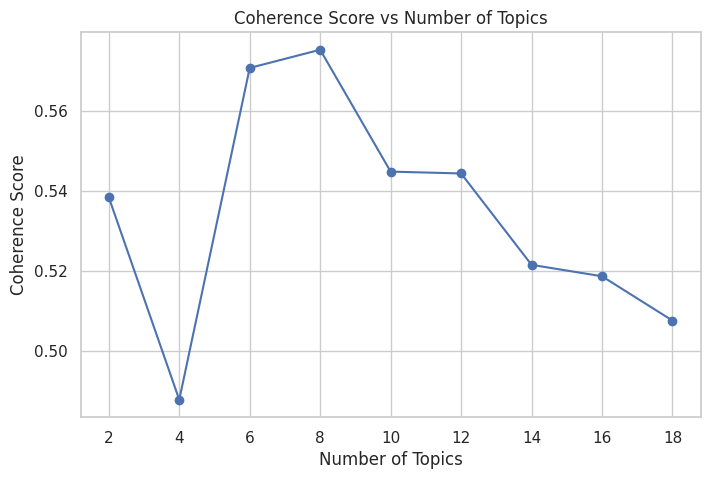

Best number of topics: 8


In [87]:
topic_range_cleaned, coherences_cleaned = plot_coherence_vs_topics(cleaned_texts)

max_index_cleaned = coherences_cleaned.index(max(coherences_cleaned))
best_num_topics = topic_range_cleaned[max_index_cleaned]

print(f"Best number of topics: {best_num_topics}")

In [88]:
lda_model_cleaned, corpus_cleaned, dictionary_cleaned, tokenized_docs_cleaned = perform_topic_modeling(cleaned_texts,best_num_topics,30)

Coherence Score: 0.5754
Topic 0: 0.044*"erson" + 0.029*"icle" + 0.024*"accot" + 0.021*"urity" + 0.014*"subje" + 0.014*"cision" + 0.014*"database" + 0.013*"testing" + 0.012*"alert" + 0.011*"management"
Topic 1: 0.044*"ersonal" + 0.030*"rovide" + 0.023*"urose" + 0.021*"rotection" + 0.020*"rocessing" + 0.018*"rocesse" + 0.017*"subje" + 0.016*"aroriate" + 0.012*"icle" + 0.012*"imose"
Topic 2: 0.067*"child" + 0.036*"icle" + 0.030*"objection" + 0.023*"default" + 0.018*"roller" + 0.014*"phone" + 0.012*"publication" + 0.011*"profile" + 0.011*"legitimate" + 0.008*"september"
Topic 3: 0.058*"rovide" + 0.029*"rocesse" + 0.028*"urose" + 0.025*"rocessing" + 0.021*"rocessor" + 0.016*"rocess" + 0.016*"accot" + 0.016*"erence" + 0.015*"tion" + 0.014*"ssion"
Topic 4: 0.028*"ract" + 0.026*"argument" + 0.024*"consent" + 0.018*"roller" + 0.017*"complainant" + 0.017*"partly" + 0.014*"product" + 0.014*"argue" + 0.013*"ibid" + 0.012*"image"
Topic 5: 0.049*"commissioner" + 0.010*"attack" + 0.010*"june" + 0.010

In [90]:
import glob

# Adjust the folder path as needed
pdf_folder = "gdpr_pdfs"  # Update this!
pdf_files = glob.glob(os.path.join(pdf_folder, "*.pdf"))

In [91]:
# Assign dominant topic to each document
dominant_topics = []
filenames = list(texts.keys())  # assuming 'texts' is a dict {filename: text}

for i, bow in enumerate(corpus_cleaned):
    topic_dist = lda_model_cleaned.get_document_topics(bow)
    top_topic = max(topic_dist, key=lambda x: x[1])  # (topic_id, confidence)
    dominant_topics.append({
        "Filename": os.path.basename(filenames[i]).replace(".pdf", ""),
        "Dominant_Topic": top_topic[0],
        "Topic_Confidence": top_topic[1]
    })

# Convert to DataFrame
doc_topics_df = pd.DataFrame(dominant_topics)
doc_topics_df.set_index("Filename", inplace=True)

# Show result
print(doc_topics_df)
doc_topics_df.to_csv('doc_topics.csv')

           Dominant_Topic  Topic_Confidence
Filename                                   
ETid-875                4              1.00
ETid-552                0              0.95
ETid-1373               2              0.93
ETid-1422               5              0.91
ETid-2317               5              1.00
ETid-847                0              0.24
ETid-1677               0              0.24
ETid-570                0              0.63
ETid-689                0              1.00
ETid-1910               0              0.24
ETid-1461               5              1.00
ETid-930                5              1.00
ETid-1965               1              0.97
ETid-752                5              0.86
ETid-440                5              1.00
ETid-485                3              0.82
ETid-1564               5              0.62
ETid-1009               7              1.00
ETid-1188               5              0.97
ETid-1190               4              0.66
ETid-987                0       

In [92]:
merged = doc_topics_df.merge(metadata_df_cleaned, left_index=True, right_on='ETid', how='left')
merged.head()


,Dominant_Topic,Topic_Confidence,ETid,Country,Authority,Date of Decision,Fine [€],Controller/Processor,Sector,Quoted Art.,Type,Summary
38,4,1.00,ETid-875,IRELAND,Data Protection Authority of Ireland,2021-10-06 00:00:00,0,Facebook Ireland Limited,"Media, Telecoms and Broadcasting","[5 (1) a) GDPR, 12 (1) GDPR, 13 (1) c) GDPR]",Insufficient fulfilment of information obligat...,The organization 'None of your business' (NOYB...
43,0,0.95,ETid-552,IRELAND,Data Protection Authority of Ireland,2020-12-17 00:00:00,70000,University College Dublin,Public Sector and Education,"[5 (1) e), f) GDPR, 32 (1) GDPR, 33 (1) GDPR]",Insufficient technical and organisational meas...,The Irish DPA (DPC) fined University College D...
32,2,0.93,ETid-1373,IRELAND,Data Protection Authority of Ireland,2022-09-05 00:00:00,405000000,"Meta Platforms, Inc.","Media, Telecoms and Broadcasting","[5 (1) a), c) GDPR, 6 (1) GDPR, 12 (1) GDPR, 2...",Non-compliance with general data processing pr...,The Irish DPA (DPC) has imposed a fine of EUR ...
7,5,0.91,ETid-1422,UNITED KINGDOM,Information Commissioner (ICO),2022-10-04 00:00:00,1547000,Easylife Ltd.,Industry and Commerce,"[5 (1) a) GDPR, 6 GDPR, 9 GDPR, 13 (1) c) GDPR...",Insufficient legal basis for data processing,"The UK DPA has imposed a fine of EUR 1,547,000..."
3,5,1.00,ETid-2317,UNITED KINGDOM,Information Commissioner (ICO),2024-04-30 00:00:00,8700,Central Young Men’s Christian Association,Individuals and Private Associations,"[5 (1) f) GDPR, 32 (1), (2) GDPR]",Insufficient technical and organisational meas...,The UK DPA (ICO) has fined the Central Young M...


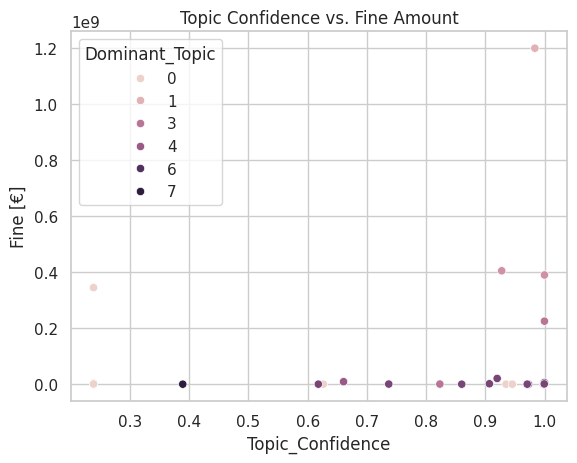

In [93]:
# Assuming 'merged_df' contains your data
sns.scatterplot(data=merged, x='Topic_Confidence', y='Fine [€]', hue='Dominant_Topic')
plt.title('Topic Confidence vs. Fine Amount')
plt.show()

<ipython-input-94-0fb93372d7b6>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged, x='Dominant_Topic', y='Fine [€]', palette='viridis')
<ipython-input-94-0fb93372d7b6>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged, x='Dominant_Topic', palette='Set2')


Text(0.5, 0, 'Dominant Topic')

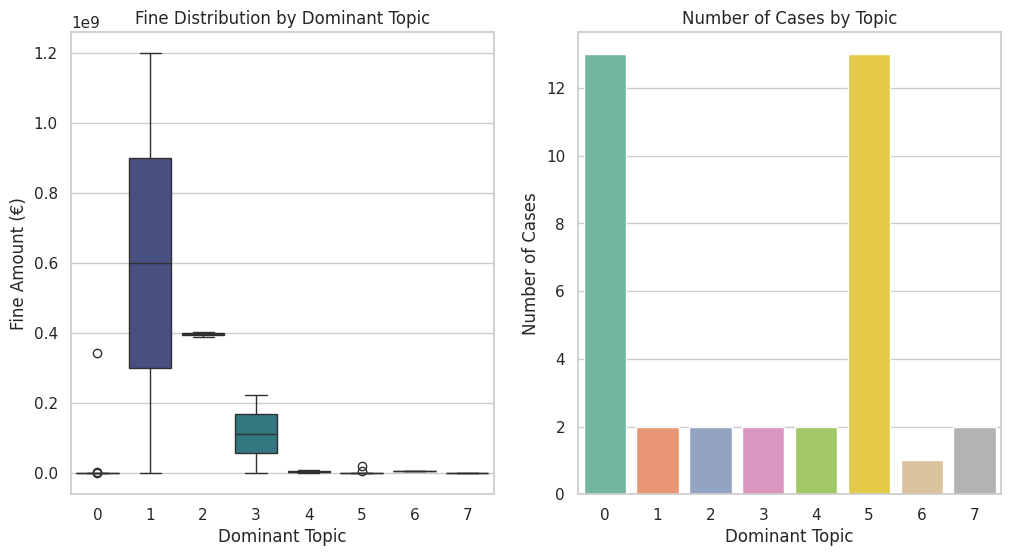

In [94]:
# Create visualizations
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Plot 1: Fine Amounts by Topic
plt.subplot(1, 2, 1)
sns.boxplot(data=merged, x='Dominant_Topic', y='Fine [€]', palette='viridis')
plt.title("Fine Distribution by Dominant Topic")
plt.ylabel("Fine Amount (€)")
plt.xlabel("Dominant Topic")

# Plot 2: Number of Cases per Topic
plt.subplot(1, 2, 2)
sns.countplot(data=merged, x='Dominant_Topic', palette='Set2')
plt.title("Number of Cases by Topic")
plt.ylabel("Number of Cases")
plt.xlabel("Dominant Topic")

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-95-cccfaf95db3f>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged, x='Dominant_Topic', y='Log_Fine', palette='coolwarm')
<ipython-input-95-cccfaf95db3f>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_fines, x='Dominant_Topic', y='Fine [€]', palette='mako')


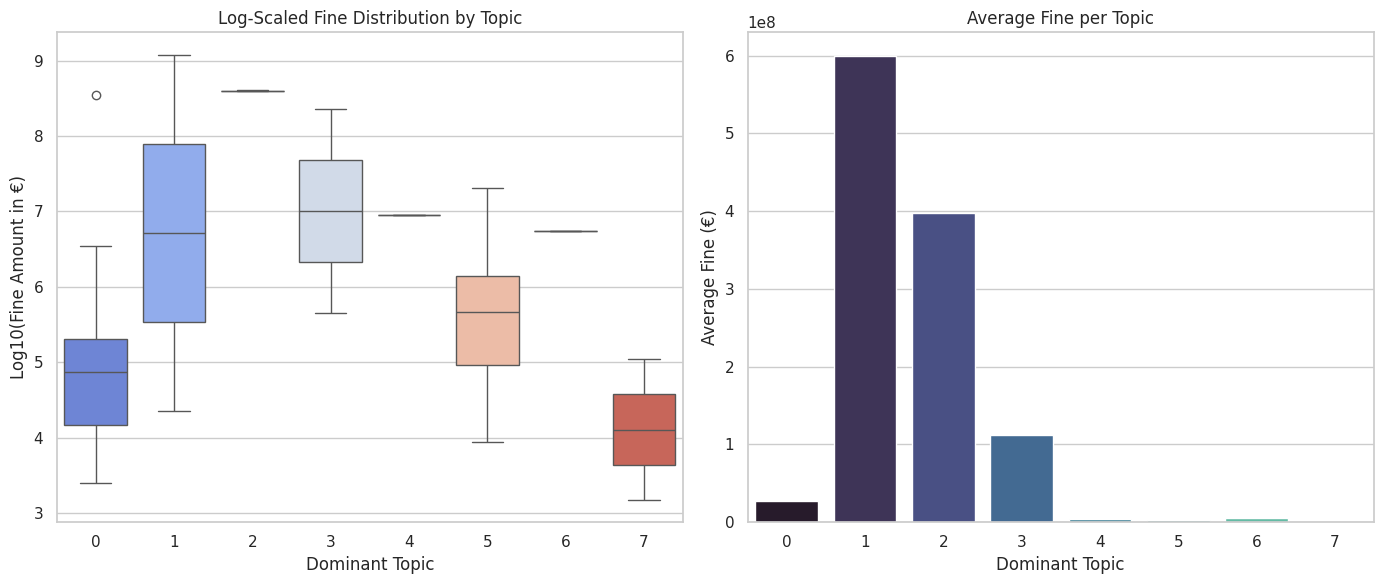

In [95]:
import numpy as np
# Log-transform fine amounts
merged['Log_Fine'] = np.log10(merged['Fine [€]'])

# Set up plots
plt.figure(figsize=(14, 6))

# Boxplot with log-scaled fines
plt.subplot(1, 2, 1)
sns.boxplot(data=merged, x='Dominant_Topic', y='Log_Fine', palette='coolwarm')
plt.title("Log-Scaled Fine Distribution by Topic")
plt.ylabel("Log10(Fine Amount in €)")
plt.xlabel("Dominant Topic")

# Average fine per topic (bar)
plt.subplot(1, 2, 2)
mean_fines = merged.groupby('Dominant_Topic')['Fine [€]'].mean().reset_index()
sns.barplot(data=mean_fines, x='Dominant_Topic', y='Fine [€]', palette='mako')
plt.title("Average Fine per Topic")
plt.ylabel("Average Fine (€)")
plt.xlabel("Dominant Topic")

plt.tight_layout()
plt.show()

In [97]:
import scipy.stats as stats

# Assuming 'confidence_scores' and 'fine_amounts' are arrays
correlation, p_value = stats.pearsonr( merged['Topic_Confidence'], merged['Fine [€]'])
print(f"Correlation: {correlation}, p-value: {p_value}")

Correlation: 0.1266923155409252, p-value: 0.4549382026324211


In [98]:
# Assuming 'merged_df' contains your data
grouped_df = merged.groupby(['Dominant_Topic', pd.cut(merged['Topic_Confidence'], bins=4, )])['Fine [€]'].median()

pd.set_option('display.float_format', '{:.2f}'.format)

print(grouped_df)

Dominant_Topic  Topic_Confidence
0               (0.238, 0.429]        108500.00
                (0.429, 0.619]              NaN
                (0.619, 0.81]          85000.00
                (0.81, 1.0]            72500.00
1               (0.238, 0.429]              NaN
                (0.429, 0.619]              NaN
                (0.619, 0.81]               NaN
                (0.81, 1.0]        600011250.00
2               (0.238, 0.429]              NaN
                (0.429, 0.619]              NaN
                (0.619, 0.81]               NaN
                (0.81, 1.0]        397500000.00
3               (0.238, 0.429]              NaN
                (0.429, 0.619]              NaN
                (0.619, 0.81]               NaN
                (0.81, 1.0]        112725000.00
4               (0.238, 0.429]              NaN
                (0.429, 0.619]              NaN
                (0.619, 0.81]        9000000.00
                (0.81, 1.0]                0.00
5      

<ipython-input-98-937e3c42a391>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = merged.groupby(['Dominant_Topic', pd.cut(merged['Topic_Confidence'], bins=4, )])['Fine [€]'].median()


In [99]:
class RandomTopicModel:
    def __init__(self, num_topics, vocab_size):
        self.num_topics = num_topics
        self.vocab_size = vocab_size

    def get_topics(self):
        # Return a uniform distribution for each topic across all vocab terms
        return np.ones((self.num_topics, self.vocab_size)) / self.vocab_size


In [107]:
random_model = RandomTopicModel(num_topics=lda_model.num_topics, vocab_size=len(dictionary))

In [108]:
lda_coherence_model = CoherenceModel(model=lda_model_cleaned, texts=tokenized_docs_cleaned, dictionary=dictionary_cleaned, coherence='c_v')
lda_coherence = lda_coherence_model.get_coherence()

random_coherence_model = CoherenceModel(model=random_model, texts=tokenized_docs_cleaned, dictionary=dictionary_cleaned, coherence='c_v')
random_coherence = random_coherence_model.get_coherence()


LDA Coherence: 0.5754107743395893
Random Coherence: 0.45694352602917465


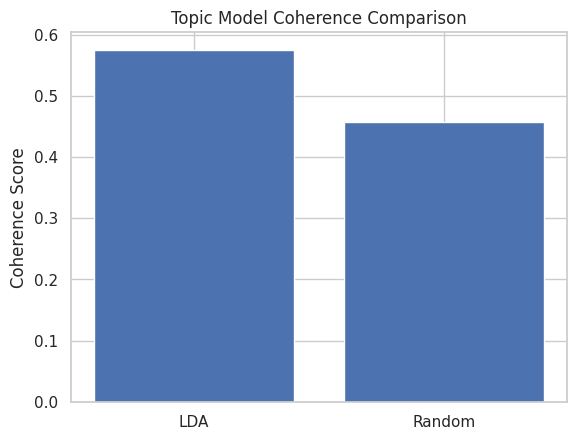

In [109]:
print(f"LDA Coherence: {lda_coherence}")
print(f"Random Coherence: {random_coherence}")

plt.bar(['LDA', 'Random'], [lda_coherence, random_coherence])
plt.title('Topic Model Coherence Comparison')
plt.ylabel('Coherence Score')
plt.show()

In [110]:
def visualize_topics(lda_model, corpus, dictionary):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
    return vis  # Use pyLDAvis.display(vis) or pyLDAvis.save_html(vis, 'lda.html')

In [111]:
visualize_topics(lda_model_cleaned, corpus_cleaned, dictionary_cleaned)

PreparedData(topic_coordinates=          x     y  topics  cluster  Freq
topic                                   
3      0.28 -0.05       1        1 20.18
5     -0.10  0.14       2        1 18.71
1      0.23 -0.03       3        1 18.07
2     -0.10 -0.05       4        1 16.40
0      0.02  0.18       5        1  8.38
6     -0.09 -0.15       6        1  6.64
4     -0.15 -0.15       7        1  6.54
7     -0.08  0.10       8        1  5.08, topic_info=              Term    Freq   Total Category  logprob  loglift
759         rovide 1506.00 1506.00  Default    30.00    30.00
133          child 1067.00 1067.00  Default    29.00    29.00
1164  commissioner  807.00  807.00  Default    28.00    28.00
1377       ersonal  953.00  953.00  Default    27.00    27.00
427           icle  926.00  926.00  Default    26.00    26.00
...            ...     ...     ...      ...      ...      ...
39       agreement   39.39  168.05   Topic8    -4.73     1.53
286         easily   24.93   75.67   Topic8    -5.19     1.87
1571        fction   23.96   80.78   Topic8    -5.23     1.76
848     technology   22.28   87.22   Topic8    -5.30     1.61
916          video   21.13   74.85   Topic8    -5.35     1.71

[470 rows x 6 columns], token_table=      Topic  Freq        Term
term                         
5         1  0.02  accessible
5         2  0.37  accessible
5         3  0.15  accessible
5         5  0.02  accessible
5         6  0.04  accessible
...     ...   ...         ...
938       6  0.09     writing
938       7  0.09     writing
938       8  0.57     writing
1535      5  0.69        xiii
1535      8  0.17        xiii

[1608 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 2, 3, 1, 7, 5, 8])

<ipython-input-112-a77693d0fd26>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='probability', y='word', data=df, palette='viridis')


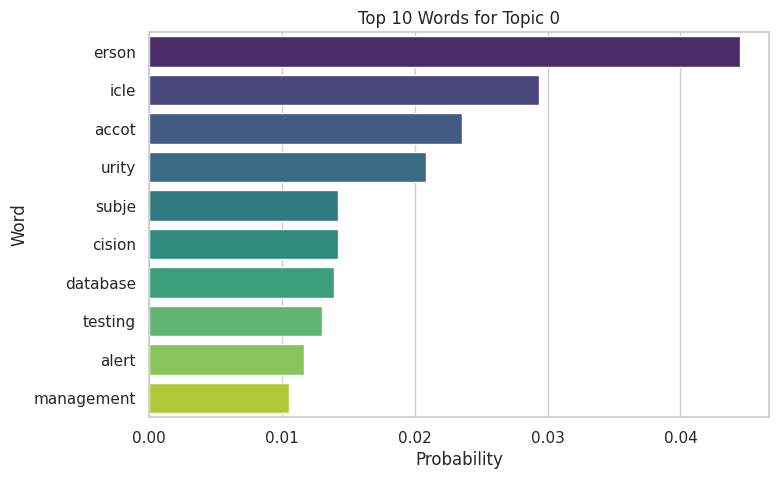

<ipython-input-112-a77693d0fd26>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='probability', y='word', data=df, palette='viridis')


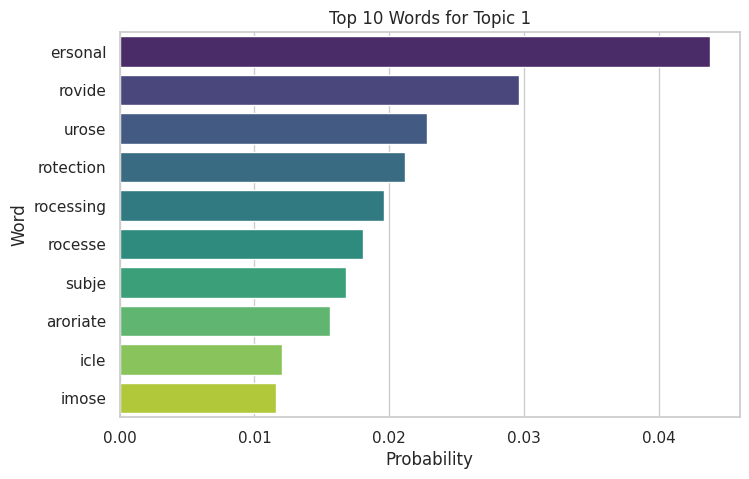

<ipython-input-112-a77693d0fd26>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='probability', y='word', data=df, palette='viridis')


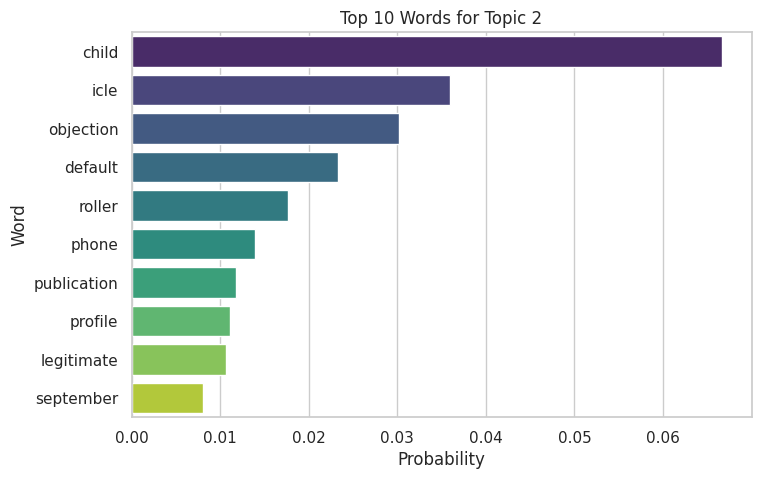

<ipython-input-112-a77693d0fd26>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='probability', y='word', data=df, palette='viridis')


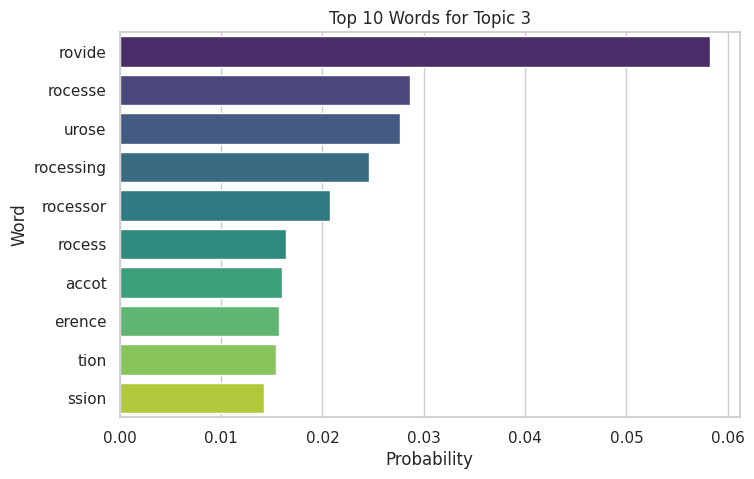

<ipython-input-112-a77693d0fd26>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='probability', y='word', data=df, palette='viridis')


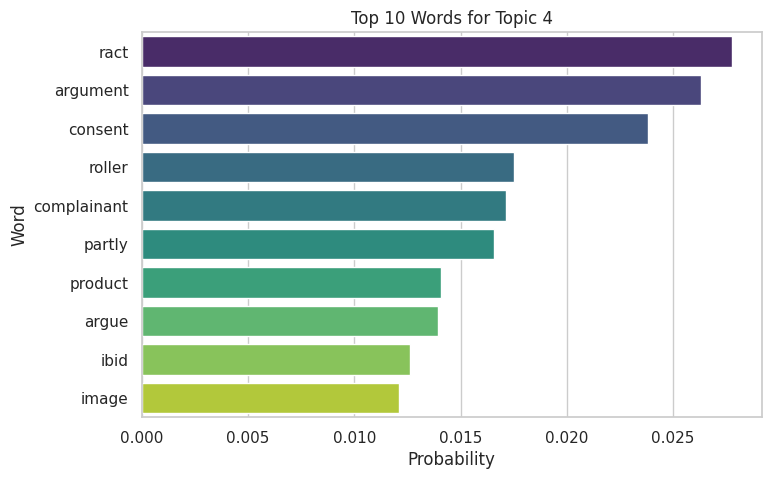

<ipython-input-112-a77693d0fd26>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='probability', y='word', data=df, palette='viridis')


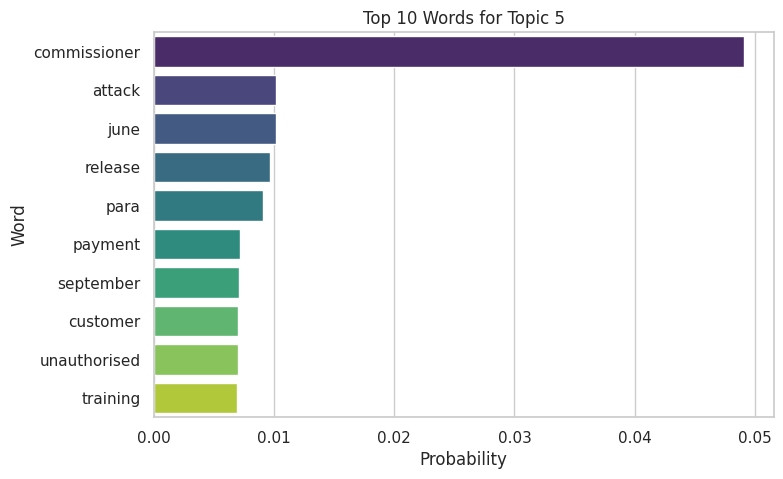

<ipython-input-112-a77693d0fd26>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='probability', y='word', data=df, palette='viridis')


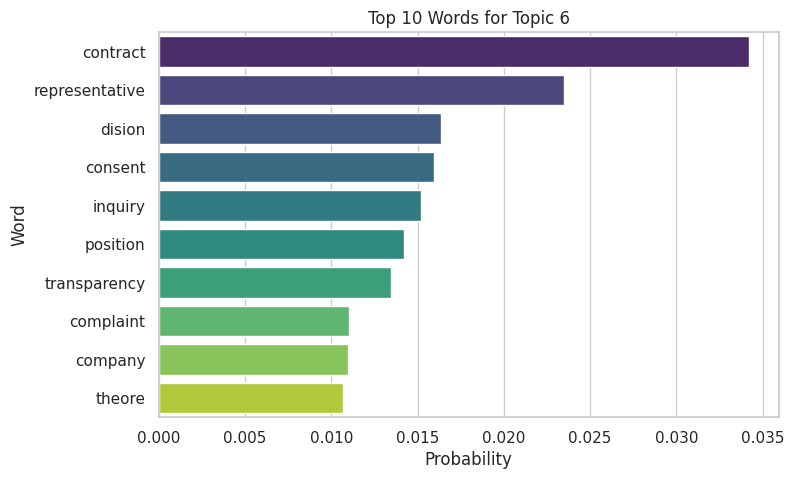

<ipython-input-112-a77693d0fd26>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='probability', y='word', data=df, palette='viridis')


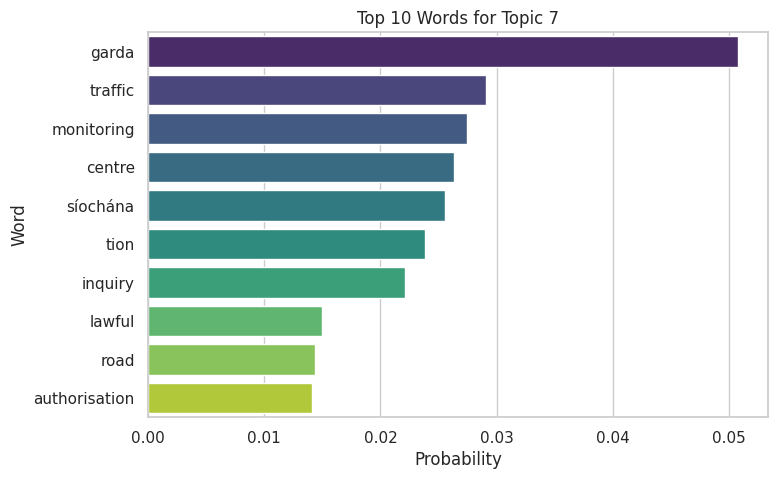

In [112]:
# Function to get top words for each topic
def plot_top_words(lda_model, num_words=10):
    for topic_id in range(lda_model.num_topics):
        words_probs = lda_model.show_topic(topic_id, topn=num_words)
        words, probs = zip(*words_probs)
        df = pd.DataFrame({'word': words, 'probability': probs})
        plt.figure(figsize=(8, 5))
        sns.barplot(x='probability', y='word', data=df, palette='viridis')
        plt.title(f"Top {num_words} Words for Topic {topic_id}")
        plt.xlabel("Probability")
        plt.ylabel("Word")
        plt.show()

plot_top_words(lda_model_cleaned)


In [113]:
lda_model_cleaned.save('lda.model')